1. Lectura del archivo de Google ya tratado.

In [12]:
import pandas as pd

# Read Parquet file into a DataFrame
df = pd.read_parquet(r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\datos_google_completo.parquet")
df.head(2)

,user_id,rating,text,gmap_id,avg_rating,num_of_reviews,hours,MISC,category_group,County,MedianHH_Income,Median_Home_Value,Median_RE_Taxes
0,111125856245625410393,5,My happy place. I love their coffee!,0x89c1352001dc66d1:0xb8ca54f815dbb1bf,4.1,8,"[[Wednesday, 5AM–8PM], [Thursday, 5AM–8PM], [F...",{'Accessibility': ['Wheelchair accessible entr...,Cafés & Bakeries,BURLINGTON,98055.508621,265976.106195,7031.115044
1,111125856245625410393,5,My happy place. I love their coffee!,0x89c1352001dc66d1:0xb8ca54f815dbb1bf,4.1,8,"[[Wednesday, 5AM–8PM], [Thursday, 5AM–8PM], [F...",{'Accessibility': ['Wheelchair accessible entr...,Cafés & Bakeries,CAMDEN,82476.945736,210589.843750,6792.437500


2. Analicemos la variable MISC

In [16]:
import numpy as np

def flatten_misc(misc):
    words = []
    if isinstance(misc, dict):
        for v in misc.values():
            if isinstance(v, np.ndarray):
                words.extend([str(item).lower() for item in v if isinstance(item, str)])
            elif isinstance(v, list):
                words.extend([str(item).lower() for item in v if isinstance(item, str)])
            elif isinstance(v, str):
                words.append(v.lower())
            # ignore None or unexpected types
    return words

df['MISC_WORDS'] = df['MISC'].apply(flatten_misc)


3. Creamos dummies que consideramos puedan explicar los sentimientos

In [18]:
dummy_keys = [
    'drive-through', 'curbside pickup', 'takeout', 'delivery',
    'cozy', 'casual', 'college students', 'groups', 'family-friendly',
    'dinner', 'dessert', 'breakfast', 'counter service', 'quick visit',"lunch",
    'Comfort food','Good for kids','Quick bite','Healthy options', 'Fast service','Vegetarian options'
]

for key in dummy_keys:
    df[key] = df['MISC_WORDS'].apply(
        lambda words: int(key in words if isinstance(words, list) else [])
    )


In [22]:
cols_to_drop = [
    'MISC', 'MISC_WORDS', 'user_id',"gmap_id"
]

df_eda= df.drop(columns=cols_to_drop)

4. Ponemos un sentimiento al texto

In [ ]:
#Limpieza y tokenizado 
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Todas las variables que tengan texto las procesamos- solo la reseña
columnas_a_normalizar = ["text"]

#Normalizar- en ingles dado que el texto es en ingles.
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


# Funcion para reprocesar el texto
def preprocess_text(text):
    # Minusculas
    text = text.lower()
    
    # Quitar puntuación
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenizar (mejor con nltk)
    tokens = word_tokenize(text)
    
    # Quitar stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatizar
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Reconstruir el texto
    return ' '.join(tokens)


# Aplicar funcion a las columnas que tienen texto
for column in columnas_a_normalizar:
    df_eda.loc[:, column] = df_eda[column].apply(
    lambda x: preprocess_text(x) if pd.notnull(x) else x
)

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

#Borrar filas con vacios
df_eda = df_eda.dropna(subset=["text"])

#Resetear indice
df_eda = df_eda.reset_index(drop=True)

# Para la variable Google- text
limpios_text=df_eda["text"]
#Instanciamos
vectorizer = CountVectorizer()
# Initializar Vader
analyzer = SentimentIntensityAnalyzer()
X = vectorizer.fit_transform(limpios_text)

#Creamos la funcion vader de sentimiento y obtenemos la variable sentimiento de Vader Compund- toca sacar dos
def vader_sentiment(text):
    # Get VADER scores
    scores = analyzer.polarity_scores(text)

    # Classify based on compound score
    if scores['compound'] >= 0.05:
        sentiment = "Positive"
    elif scores['compound'] <= -0.05:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"

    # Return all scores + classification
    return {
        "vader_neg_google": scores["neg"],
        "vader_neu_google": scores["neu"],
        "vader_pos_google": scores["pos"],
        "vader_compound_google": scores["compound"],
        "vader_sentiment_google": sentiment
    }


# Apply VADER and expand results into new columns
df_google_review= df_eda.join(
   df_eda["text"].apply(lambda x: pd.Series(vader_sentiment(x)))
)

5. Particionamos la data- el objetivo es encontrar el segmento que tiene problemas y que County

In [45]:
#Particion Google
df_fast_food=df_google_review[ df_google_review['category_group']=="Fast Food"].copy()
df_pizza_pasta=df_google_review[ df_google_review['category_group']=="Pizza and Pasta"].copy()
df_cocina_asiatica=df_google_review[ df_google_review['category_group']=="Asian Cuisine"].copy()
df_cafe_bakery=df_google_review[ df_google_review['category_group']=="Cafés & Bakeries"].copy()
df_latin=df_google_review[ df_google_review['category_group']=="Latin & Mexican"].copy()

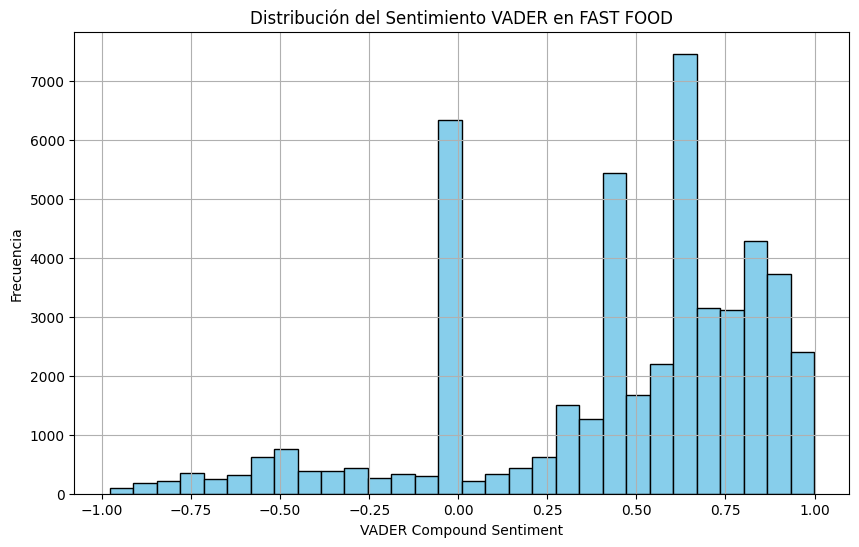

In [46]:
import matplotlib.pyplot as plt
# Histograma de sentimiento VADER

plt.figure(figsize=(10, 6))
plt.hist(df_fast_food['vader_compound_google'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución del Sentimiento VADER en FAST FOOD')
plt.xlabel('VADER Compound Sentiment')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [51]:
# Agrupar por 'County' y calcular el promedio del sentimiento por pueblo
promedios_sentimiento = (
    df_fast_food.groupby('County')['vader_compound_google']
    .mean()
    .reset_index()
    .rename(columns={'vader_compound_google': 'Average_VADER_Sentiment'})
    .sort_values(by='Average_VADER_Sentiment')  # Ordenar de menor a mayor
)

# Mostrar la tabla
print(promedios_sentimiento)


        County  Average_VADER_Sentiment
16       SALEM                 0.271791
5   CUMBERLAND                 0.347068
7   GLOUCESTER                 0.395308
10      MERCER                 0.407612
8       HUDSON                 0.411075
14       OCEAN                 0.413271
6        ESSEX                 0.421213
17    SOMERSET                 0.423577
19       UNION                 0.437339
20      WARREN                 0.440854
2   BURLINGTON                 0.445136
11   MIDDLESEX                 0.445494
3       CAMDEN                 0.452104
15     PASSAIC                 0.454905
13      MORRIS                 0.468640
1       BERGEN                 0.480291
18      SUSSEX                 0.502969
12    MONMOUTH                 0.505387
4     CAPE MAY                 0.513264
0     ATLANTIC                 0.540865
9    HUNTERDON                 0.554307


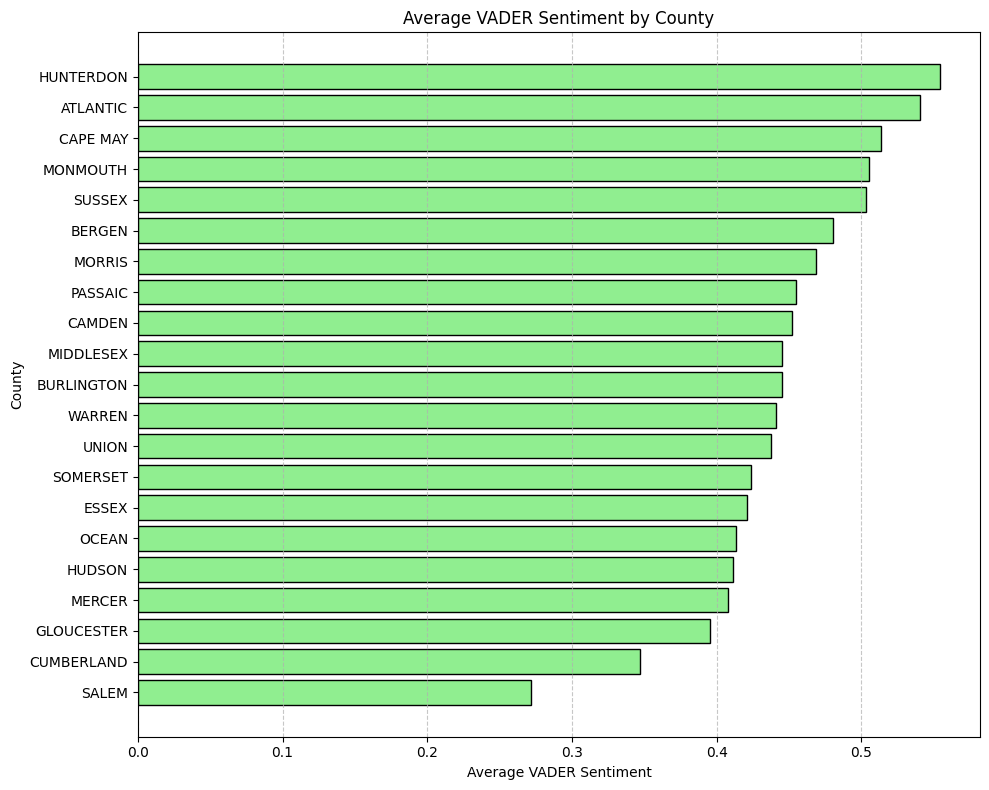

In [52]:
import matplotlib.pyplot as plt

# Crear figura
plt.figure(figsize=(10, 8))

# Gráfico de barras horizontal
plt.barh(
    promedios_sentimiento['County'],
    promedios_sentimiento['Average_VADER_Sentiment'],
    color='lightgreen',
    edgecolor='black'
)

# Títulos y etiquetas
plt.xlabel('Average VADER Sentiment')
plt.ylabel('County')
plt.title('Average VADER Sentiment by County')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

***Conclusión- El county SALEM tiene problemas para tener restaurantes de calidad en la categoría Fast Food.

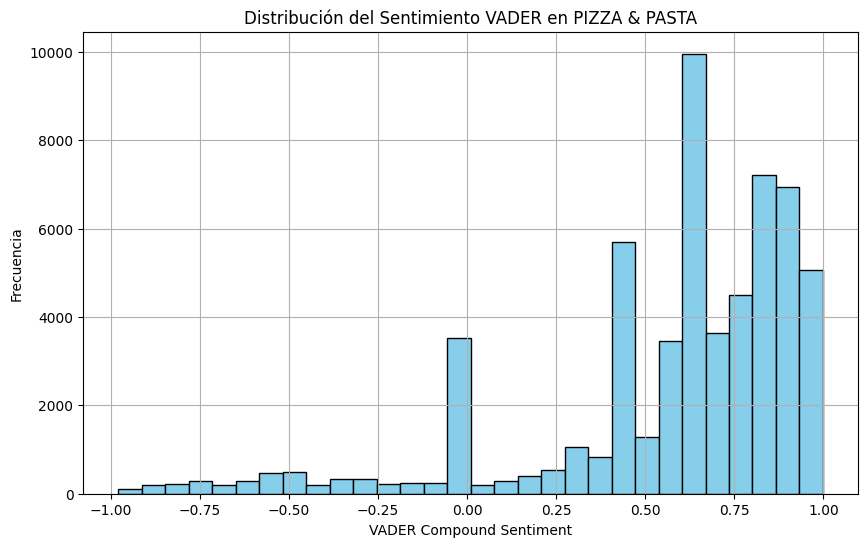

In [63]:
import matplotlib.pyplot as plt
# Histograma de sentimiento VADER

plt.figure(figsize=(10, 6))
plt.hist(df_pizza_pasta['vader_compound_google'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución del Sentimiento VADER en PIZZA & PASTA')
plt.xlabel('VADER Compound Sentiment')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [64]:
# Agrupar por 'County' y calcular el promedio del sentimiento por pueblo
promedios_sentimiento = (
    df_pizza_pasta.groupby('County')['vader_compound_google']
    .mean()
    .reset_index()
    .rename(columns={'vader_compound_google': 'Average_VADER_Sentiment'})
    .sort_values(by='Average_VADER_Sentiment')  # Ordenar de menor a mayor
)

# Mostrar la tabla
print(promedios_sentimiento)


        County  Average_VADER_Sentiment
8       HUDSON                 0.536272
16       SALEM                 0.547552
19       UNION                 0.549683
6        ESSEX                 0.552895
5   CUMBERLAND                 0.554908
11   MIDDLESEX                 0.560092
18      SUSSEX                 0.563520
1       BERGEN                 0.564653
17    SOMERSET                 0.565293
4     CAPE MAY                 0.566533
2   BURLINGTON                 0.574316
3       CAMDEN                 0.574887
15     PASSAIC                 0.575554
10      MERCER                 0.583590
7   GLOUCESTER                 0.585550
20      WARREN                 0.590445
0     ATLANTIC                 0.591128
14       OCEAN                 0.602998
12    MONMOUTH                 0.611128
13      MORRIS                 0.612964
9    HUNTERDON                 0.636828


**** Conclusión- no hay problemas evidentes en la categoria PIZZA AND PASTA. Es positivo y parejo.

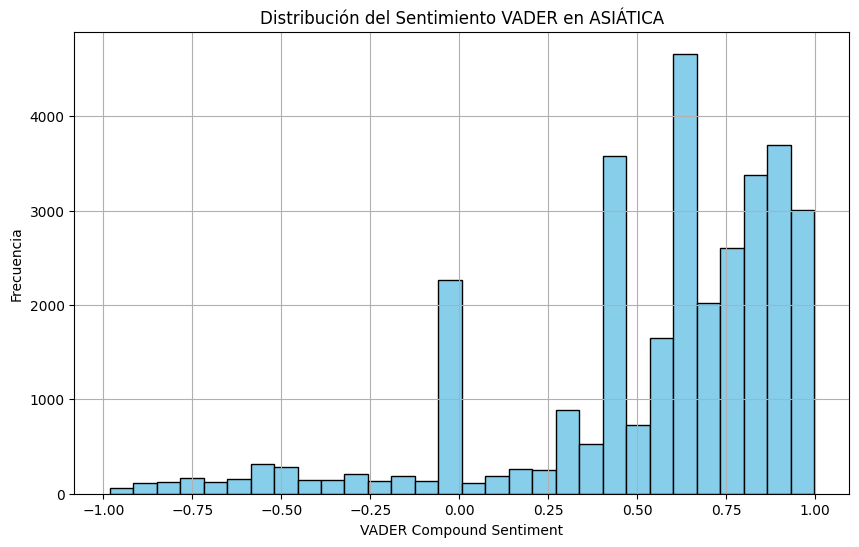

In [65]:
plt.figure(figsize=(10, 6))
plt.hist(df_cocina_asiatica['vader_compound_google'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución del Sentimiento VADER en ASIÁTICA')
plt.xlabel('VADER Compound Sentiment')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [66]:
# Agrupar por 'County' y calcular el promedio del sentimiento por pueblo
promedios_sentimiento = (
    df_cocina_asiatica.groupby('County')['vader_compound_google']
    .mean()
    .reset_index()
    .rename(columns={'vader_compound_google': 'Average_VADER_Sentiment'})
    .sort_values(by='Average_VADER_Sentiment')  # Ordenar de menor a mayor
)

# Mostrar la tabla
print(promedios_sentimiento)


        County  Average_VADER_Sentiment
17    SOMERSET                 0.499494
16       SALEM                 0.500099
19       UNION                 0.503157
5   CUMBERLAND                 0.521975
8       HUDSON                 0.524087
6        ESSEX                 0.526964
4     CAPE MAY                 0.532445
10      MERCER                 0.540327
2   BURLINGTON                 0.544997
11   MIDDLESEX                 0.549667
15     PASSAIC                 0.561394
3       CAMDEN                 0.561410
14       OCEAN                 0.569247
1       BERGEN                 0.572585
7   GLOUCESTER                 0.578719
12    MONMOUTH                 0.579931
0     ATLANTIC                 0.580545
13      MORRIS                 0.584471
18      SUSSEX                 0.604176
20      WARREN                 0.629975
9    HUNTERDON                 0.633115


**** Tampoco hay problemas evidentes en la cocina asiatica. Positivo y parejo relativamente.

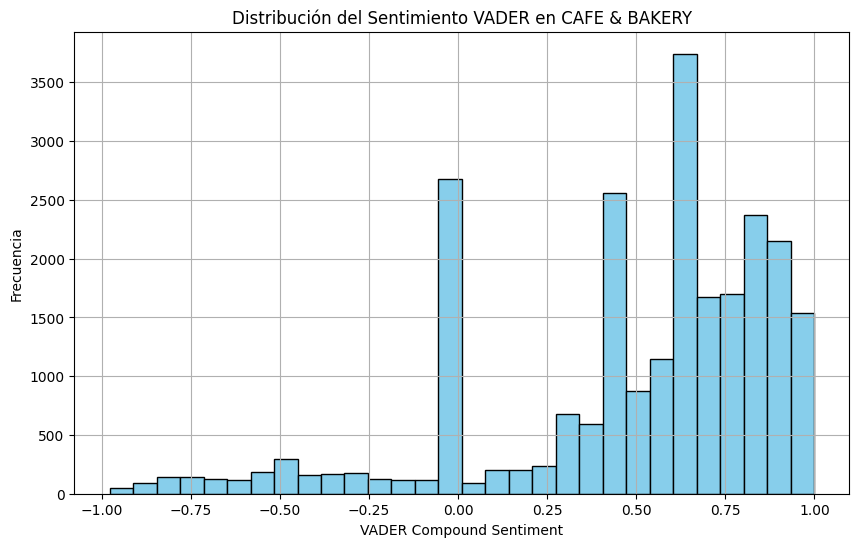

In [67]:
plt.figure(figsize=(10, 6))
plt.hist(df_cafe_bakery['vader_compound_google'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución del Sentimiento VADER en CAFE & BAKERY')
plt.xlabel('VADER Compound Sentiment')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [68]:
# Agrupar por 'County' y calcular el promedio del sentimiento por pueblo
promedios_sentimiento = (
    df_cafe_bakery.groupby('County')['vader_compound_google']
    .mean()
    .reset_index()
    .rename(columns={'vader_compound_google': 'Average_VADER_Sentiment'})
    .sort_values(by='Average_VADER_Sentiment')  # Ordenar de menor a mayor
)

# Mostrar la tabla
print(promedios_sentimiento)


        County  Average_VADER_Sentiment
18      SUSSEX                 0.387723
13      MORRIS                 0.412051
5   CUMBERLAND                 0.424235
20      WARREN                 0.424959
16       SALEM                 0.429900
2   BURLINGTON                 0.431904
3       CAMDEN                 0.440475
19       UNION                 0.444248
10      MERCER                 0.450237
11   MIDDLESEX                 0.463314
15     PASSAIC                 0.475383
17    SOMERSET                 0.488500
6        ESSEX                 0.500089
7   GLOUCESTER                 0.500599
14       OCEAN                 0.505905
1       BERGEN                 0.530369
12    MONMOUTH                 0.530840
9    HUNTERDON                 0.537613
8       HUDSON                 0.548484
4     CAPE MAY                 0.585395
0     ATLANTIC                 0.609093


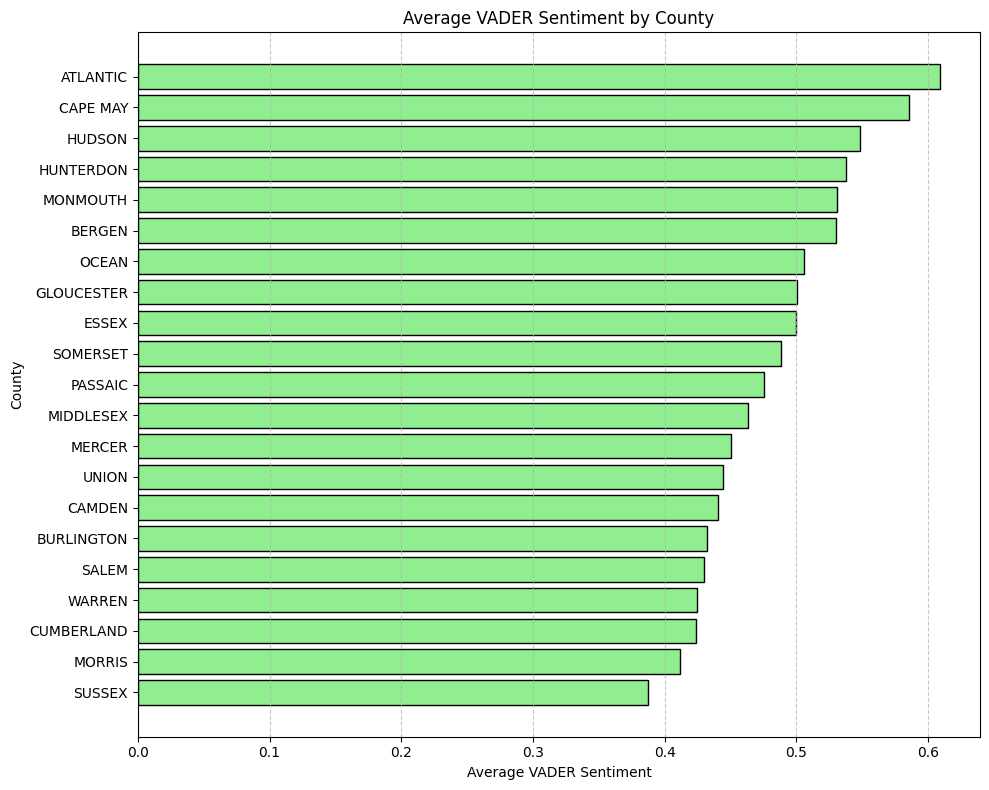

In [69]:
import matplotlib.pyplot as plt

# Crear figura
plt.figure(figsize=(10, 8))

# Gráfico de barras horizontal
plt.barh(
    promedios_sentimiento['County'],
    promedios_sentimiento['Average_VADER_Sentiment'],
    color='lightgreen',
    edgecolor='black'
)

# Títulos y etiquetas
plt.xlabel('Average VADER Sentiment')
plt.ylabel('County')
plt.title('Average VADER Sentiment by County')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

*** Conclusión- El County Sussex tiene problemas de calidad en cafe & bakery

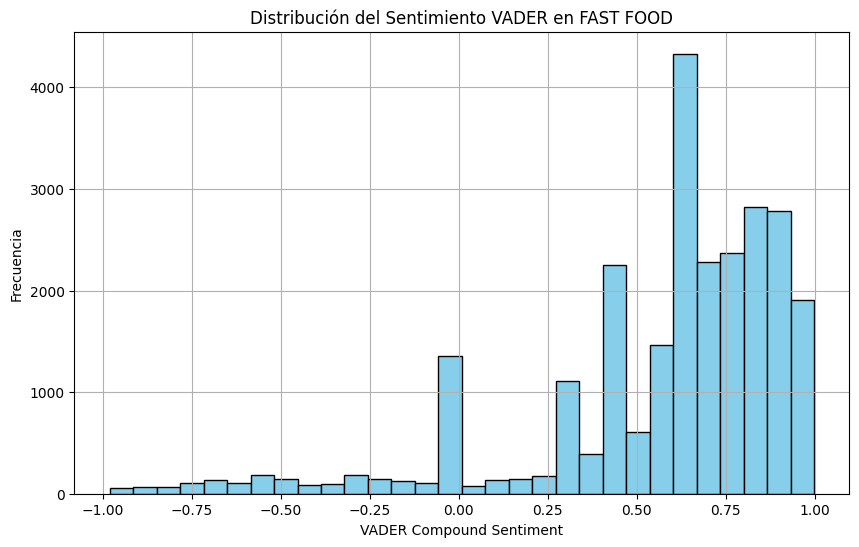

In [70]:
plt.figure(figsize=(10, 6))
plt.hist(df_latin['vader_compound_google'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución del Sentimiento VADER en FAST FOOD')
plt.xlabel('VADER Compound Sentiment')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [71]:
# Agrupar por 'County' y calcular el promedio del sentimiento por pueblo
promedios_sentimiento = (
    df_latin.groupby('County')['vader_compound_google']
    .mean()
    .reset_index()
    .rename(columns={'vader_compound_google': 'Average_VADER_Sentiment'})
    .sort_values(by='Average_VADER_Sentiment')  # Ordenar de menor a mayor
)

# Mostrar la tabla
print(promedios_sentimiento)

        County  Average_VADER_Sentiment
7   GLOUCESTER                 0.523755
9       MERCER                 0.538884
2   BURLINGTON                 0.545413
0     ATLANTIC                 0.546918
3       CAMDEN                 0.558100
17       UNION                 0.563640
6        ESSEX                 0.568741
1       BERGEN                 0.573128
15    SOMERSET                 0.576394
10   MIDDLESEX                 0.576717
14     PASSAIC                 0.579165
8       HUDSON                 0.580335
13       OCEAN                 0.585786
12      MORRIS                 0.587536
11    MONMOUTH                 0.598871
4     CAPE MAY                 0.603075
18      WARREN                 0.608069
5   CUMBERLAND                 0.628092
16      SUSSEX                 0.628104


*** No hay problemas de calidad en la categoria de comida latina- postivo y parejo.

Conclusiones- Se evidencian 2 counties que tienen problemas de calidad.

Fast Food: Salem tiene un promedio de 0.27 en el sentimiento. El más alto tiene 0.54- es el doble.
Cafe & Bakery: Sussex tiene un promedio de 0.38 en el sentimiento. El mas alto tiene 0.6

Enfoquemos el análisis en estos dos segmentos. Enviamos estos dos dataframes para realizar ML.

In [73]:
import os

# Define the folder path
output_folder = r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET"

# Save two DataFrames as CSV
df_fast_food.to_csv(os.path.join(output_folder, "df_fast_food_google.csv"), index=False, encoding="utf-8-sig")
df_cafe_bakery.to_csv(os.path.join(output_folder, "df_cafe_bakery_google.csv"), index=False, encoding="utf-8-sig")
